### Imports Needed For EDA

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

### Making CSV files for Each Relevent Feature (Do not run anymore, we saved the files)


In [3]:
"""import os
import pandas as pd

base_dir = "stress_dataset/Data"
exams = ["Final", "Midterm 1", "Midterm 2"]
eda_rows, temp_rows, acc_rows = [], [], []

def read_header(path):
    with open(path) as f:
        first = f.readline().strip().split(',')
        if len(first) == 2:
            return float(first[0]), float(first[1])
        start = float(first[0])
        freq = float(f.readline().strip().split(',')[0])
        return start, freq

for subj in os.listdir(base_dir):
    subj_path = os.path.join(base_dir, subj)
    if not subj.startswith("S") or not os.path.isdir(subj_path):
        continue

    for exam in exams:
        exam_dir = os.path.join(subj_path, exam)
        if not os.path.isdir(exam_dir):
            continue

        # --- EDA ---
        eda_path = os.path.join(exam_dir, "EDA.csv")
        eda_start, eda_freq = read_header(eda_path)
        eda = pd.read_csv(eda_path, skiprows=2, header=None, names=["value"])

        # 1) build a Series of UTC datetimes
        ts = pd.Series(eda_start + eda.index/eda_freq) \
               .pipe(pd.to_datetime, unit="s", utc=True) \
               .dt.tz_convert("US/Central")
        # 2) filter & format
        ts = ts[ts.dt.hour >= 9].dt.strftime("%Y-%m-%d %H:%M:%S")
        eda = eda.loc[ts.index].assign(timestamp=ts, Subject=subj, Exam=exam)

        eda_rows.append(eda)

        # --- TEMP ---
        temp_path = os.path.join(exam_dir, "TEMP.csv")
        temp_start, temp_freq = read_header(temp_path)
        temp = pd.read_csv(temp_path, skiprows=2, header=None, names=["value"])
        ts = pd.Series(temp_start + temp.index/temp_freq) \
               .pipe(pd.to_datetime, unit="s", utc=True) \
               .dt.tz_convert("US/Central")
        ts = ts[ts.dt.hour >= 9].dt.strftime("%Y-%m-%d %H:%M:%S")
        temp = temp.loc[ts.index].assign(timestamp=ts, Subject=subj, Exam=exam)

        temp_rows.append(temp)

        # --- ACC ---
        acc_path = os.path.join(exam_dir, "ACC.csv")
        acc_start, acc_freq = read_header(acc_path)
        acc = pd.read_csv(acc_path, skiprows=2, header=None,
                          names=["ACC_X", "ACC_Y", "ACC_Z"])
        ts = pd.Series(acc_start + acc.index/acc_freq) \
               .pipe(pd.to_datetime, unit="s", utc=True) \
               .dt.tz_convert("US/Central")
        ts = ts[ts.dt.hour >= 9].dt.strftime("%Y-%m-%d %H:%M:%S")
        acc = acc.loc[ts.index].assign(timestamp=ts, Subject=subj, Exam=exam)

        acc_rows.append(acc)

# write out
os.makedirs("cleaned_data", exist_ok=True)
pd.concat(eda_rows) .to_csv("cleaned_data/eda_data.csv",  index=False)
pd.concat(temp_rows).to_csv("cleaned_data/temp_data.csv", index=False)
pd.concat(acc_rows) .to_csv("cleaned_data/acc_data.csv.gz",
                             index=False, compression="gzip")
"""

'import os\nimport pandas as pd\n\nbase_dir = "stress_dataset/Data"\nexams = ["Final", "Midterm 1", "Midterm 2"]\neda_rows, temp_rows, acc_rows = [], [], []\n\ndef read_header(path):\n    with open(path) as f:\n        first = f.readline().strip().split(\',\')\n        if len(first) == 2:\n            return float(first[0]), float(first[1])\n        start = float(first[0])\n        freq = float(f.readline().strip().split(\',\')[0])\n        return start, freq\n\nfor subj in os.listdir(base_dir):\n    subj_path = os.path.join(base_dir, subj)\n    if not subj.startswith("S") or not os.path.isdir(subj_path):\n        continue\n\n    for exam in exams:\n        exam_dir = os.path.join(subj_path, exam)\n        if not os.path.isdir(exam_dir):\n            continue\n\n        # --- EDA ---\n        eda_path = os.path.join(exam_dir, "EDA.csv")\n        eda_start, eda_freq = read_header(eda_path)\n        eda = pd.read_csv(eda_path, skiprows=2, header=None, names=["value"])\n\n        # 1) bui

### Reading in CSV Files and Creating Grades df

In [4]:
eda_df = pd.read_csv("cleaned_data/eda_data.csv")
temp_df = pd.read_csv("cleaned_data/temp_data.csv")
acc_df = pd.read_csv("cleaned_data/acc_data.csv.gz",compression='gzip')
acc_df["magnitude"] = np.sqrt(
    acc_df["ACC_X"]**2 + acc_df["ACC_Y"]**2 + acc_df["ACC_Z"]**2
) ## this is for computing overall movement...

In [ ]:
temp_df

,value,timestamp,Subject,Exam
0,21.71,2018-12-05 10:28:54,S5,Final
1,21.71,2018-12-05 10:28:54,S5,Final
2,21.71,2018-12-05 10:28:54,S5,Final
3,21.71,2018-12-05 10:28:54,S5,Final
4,21.71,2018-12-05 10:28:55,S5,Final
...,...,...,...,...
1518631,22.97,2018-11-10 11:44:43,S9,Midterm 2
1518632,22.97,2018-11-10 11:44:44,S9,Midterm 2
1518633,22.97,2018-11-10 11:44:44,S9,Midterm 2
1518634,22.97,2018-11-10 11:44:44,S9,Midterm 2


In [ ]:
temp_df

,value,timestamp,Subject,Exam
timestamp_datetime,,,,
2018-12-05 04:28:54-06:00,21.71,2018-12-05 10:28:54,S5,Final
2018-12-05 04:28:54-06:00,21.71,2018-12-05 10:28:54,S5,Final
2018-12-05 04:28:54-06:00,21.71,2018-12-05 10:28:54,S5,Final
2018-12-05 04:28:54-06:00,21.71,2018-12-05 10:28:54,S5,Final
2018-12-05 04:28:55-06:00,21.71,2018-12-05 10:28:55,S5,Final
...,...,...,...,...
2018-11-10 05:44:43-06:00,22.97,2018-11-10 11:44:43,S9,Midterm 2
2018-11-10 05:44:44-06:00,22.97,2018-11-10 11:44:44,S9,Midterm 2
2018-11-10 05:44:44-06:00,22.97,2018-11-10 11:44:44,S9,Midterm 2


### Plotting some visualizations, Understanding our data, Looking for Patterns

#### Temperature

/var/folders/7b/3n14tkpn43159_mb97d03mbm0000gn/T/ipykernel_67782/643535868.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(


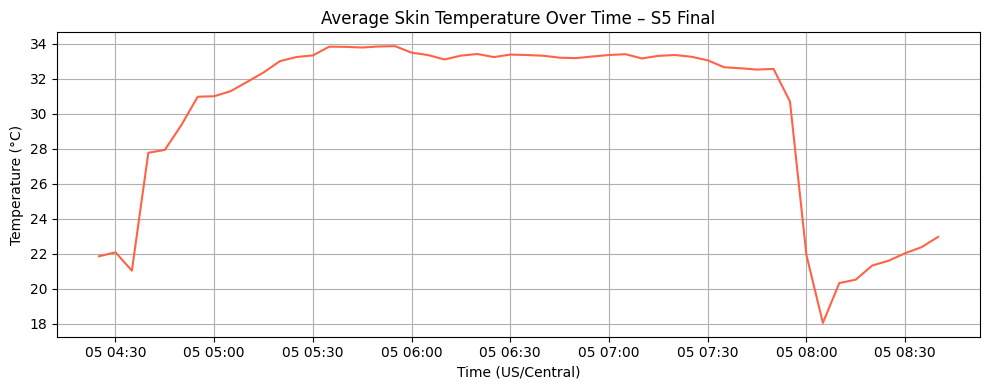

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- assume temp_df has columns Subject, Exam, value, and timestamp strings ---

# 1) Parse & convert your timestamp strings into a timezone‑aware index
temp_df["timestamp_datetime"] = (
    pd.to_datetime(
        temp_df["timestamp"],
        utc=True,
        infer_datetime_format=True,
        exact=False
    )
    .dt.tz_convert("US/Central")
)

temp_df = temp_df.set_index("timestamp_datetime")

# 2) Make sure your 'value' column is numeric
temp_df["value"] = pd.to_numeric(temp_df["value"], errors="coerce")

# 3) Group‑resample **only** on the 'value' column
temp_avg = (
    temp_df
      .groupby(["Subject", "Exam"])       # group by these two
      .resample("5min")['value']          # then resample **and select** 'value'
      .mean()                             # now mean() only sees numbers
      .reset_index()
)

# 4) Pick one example and plot
example = temp_avg.query("Subject=='S5' and Exam=='Final'")

plt.figure(figsize=(10, 4))
plt.plot(example["timestamp_datetime"], example["value"], color="tomato")
plt.title("Average Skin Temperature Over Time – S5 Final")
plt.xlabel("Time (US/Central)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Electrodermal Activity

In [ ]:

# Pick a student and exam
student = "S5"
exam = "Final"

# Filter the EDA data
eda_single = eda_df[(eda_df["Subject"] == student) & (eda_df["Exam"] == exam)].copy()
eda_single

,value,timestamp,Subject,Exam
0,0.000000,2018-12-05 10:28:54,S5,Final
1,0.002562,2018-12-05 10:28:54,S5,Final
2,0.020495,2018-12-05 10:28:54,S5,Final
3,0.021776,2018-12-05 10:28:54,S5,Final
4,0.019214,2018-12-05 10:28:55,S5,Final
...,...,...,...,...
60991,0.000000,2018-12-05 14:43:01,S5,Final
60992,0.000000,2018-12-05 14:43:02,S5,Final
60993,0.000000,2018-12-05 14:43:02,S5,Final
60994,0.000000,2018-12-05 14:43:02,S5,Final


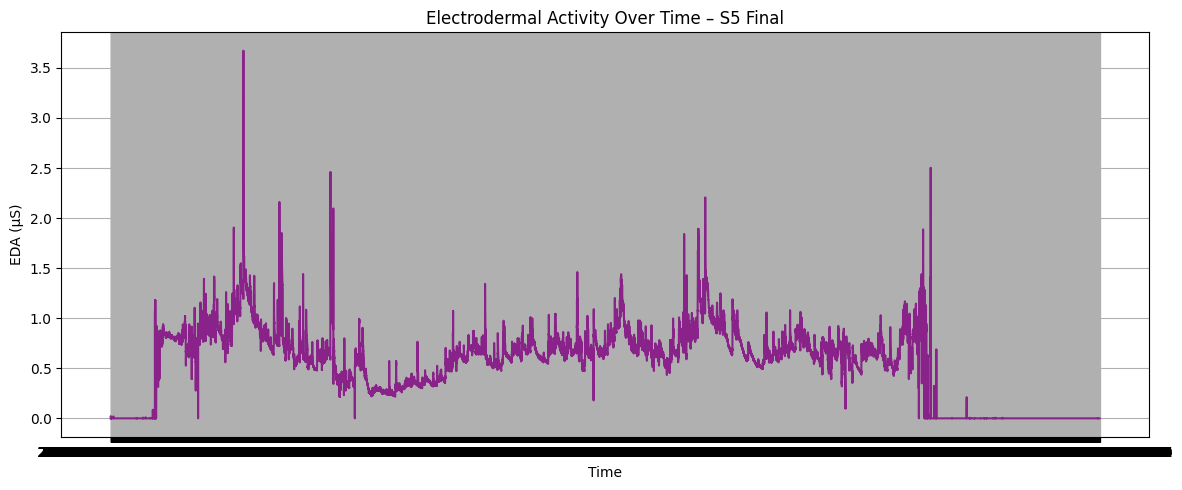

In [ ]:

# Plot
plt.figure(figsize=(12, 5))
plt.plot(eda_single["timestamp"], eda_single["value"], color="purple", alpha=0.8)
plt.title(f"Electrodermal Activity Over Time – {student} {exam}")
plt.xlabel("Time")
plt.ylabel("EDA (μS)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Accelerometer

ACC_X, ACC_Y, ACC_Z: Measure acceleration in the X, Y, and Z directions.
	•	Values are in units of 1/64 g, where g ≈ 9.81 m/s² (Earth’s gravity).
	•	The Empatica E4 device records these at a high frequency (32 Hz).

In [ ]:
#acc_df["timestamp_datetime"] = pd.to_datetime(acc_df["timestamp"], unit="s")
#acc_df

acc_df[(acc_df["Subject"] == "S8") & (acc_df["Exam"] == "Final")].sort_values('timestamp')

,ACC_X,ACC_Y,ACC_Z,timestamp,Subject,Exam,magnitude
6261956,0,-63,6,2018-12-05 10:28:59,S8,Final,63.285069
6261987,0,-62,6,2018-12-05 10:28:59,S8,Final,62.289646
6261986,-1,-63,6,2018-12-05 10:28:59,S8,Final,63.292970
6261985,0,-62,6,2018-12-05 10:28:59,S8,Final,62.289646
6261984,0,-62,6,2018-12-05 10:28:59,S8,Final,62.289646
...,...,...,...,...,...,...,...
6834629,35,51,-4,2018-12-05 15:27:15,S8,Final,61.983869
6834628,32,57,-5,2018-12-05 15:27:15,S8,Final,65.559134
6834648,54,30,-8,2018-12-05 15:27:15,S8,Final,62.289646
6834637,54,31,-10,2018-12-05 15:27:15,S8,Final,63.063460


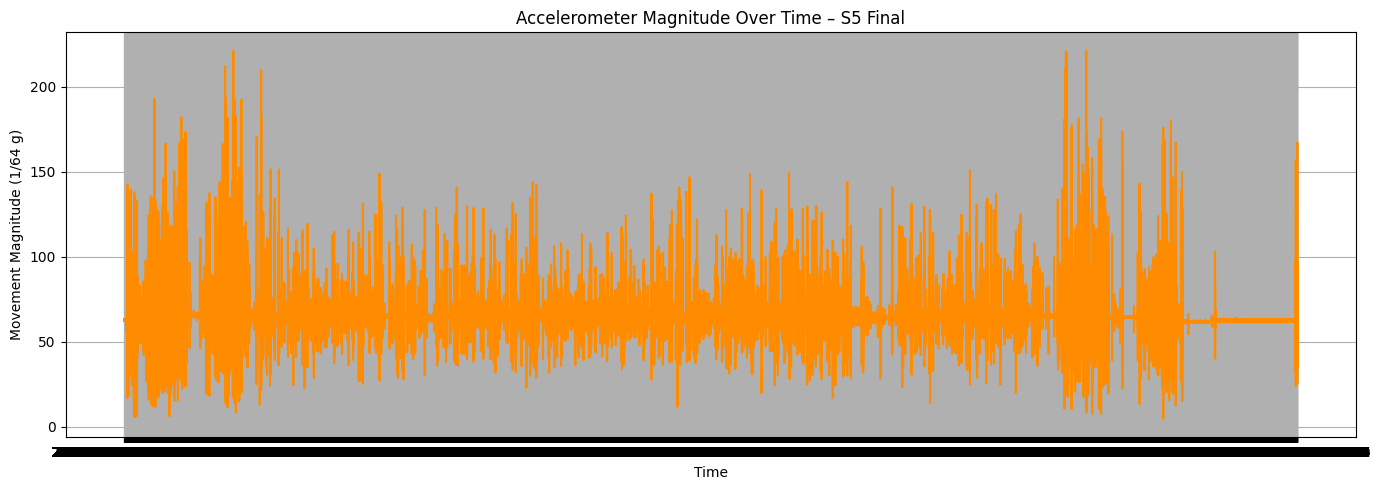

In [ ]:
# Filter for one session
single = acc_df[(acc_df["Subject"] == "S5") & (acc_df["Exam"] == "Final")]

# Plot
plt.figure(figsize=(14,5))
plt.plot(single["timestamp"], single["magnitude"], color='darkorange')
plt.title("Accelerometer Magnitude Over Time – S5 Final")
plt.xlabel("Time")
plt.ylabel("Movement Magnitude (1/64 g)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Convert timestamp and set index
acc_df["timestamp_datetime"] = pd.to_datetime(acc_df["timestamp"], unit="s")
acc_df.set_index("timestamp_datetime", inplace=True)

# Filter for just S5 Final
acc_s5_final = acc_df[(acc_df["Subject"] == "S5") & (acc_df["Exam"] == "Final")]

# Keep only numeric columns for resampling
acc_s5_final_numeric = acc_s5_final[["ACC_X", "ACC_Y", "ACC_Z"]]

# Resample and take the mean every 1 minute
acc_resampled = acc_s5_final_numeric.resample("1min").mean()

# Compute magnitude of movement
acc_resampled["magnitude"] = np.sqrt(
    acc_resampled["ACC_X"]**2 + acc_resampled["ACC_Y"]**2 + acc_resampled["ACC_Z"]**2
)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(acc_resampled.index, acc_resampled["magnitude"], color='darkorange')
plt.title("Smoothed Accelerometer Magnitude Over Time – S5 Final")
plt.xlabel("Time")
plt.ylabel("Movement Magnitude (1/64 g)")
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: non convertible value 2018-12-05 10:28:54 with the unit 's', at position 0

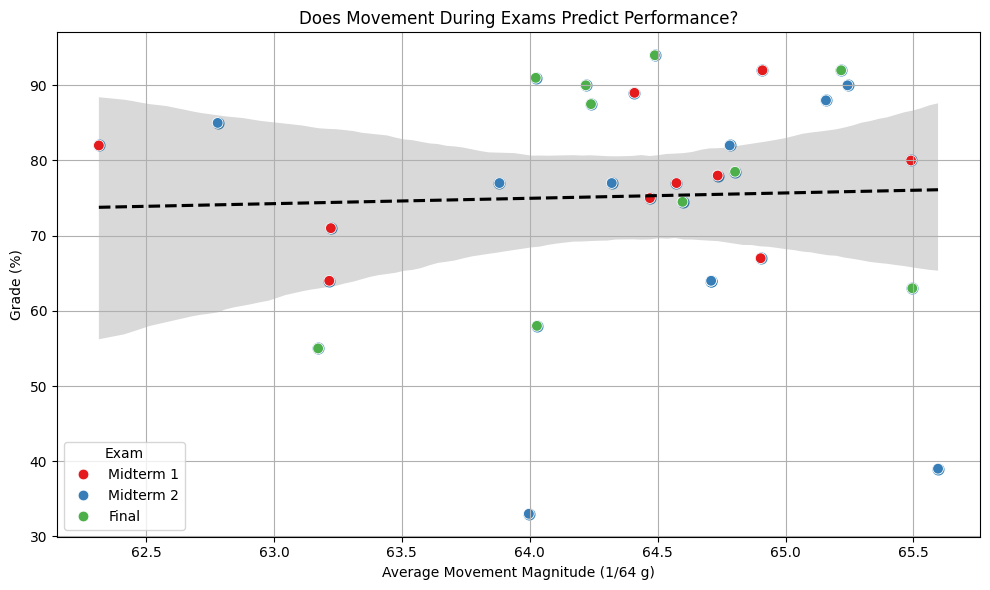

In [ ]:
# 2. Average per subject/exam
movement_summary = acc_df.groupby(["Subject", "Exam"])["magnitude"].mean().reset_index()
movement_summary.rename(columns={"magnitude": "AvgMovement"}, inplace=True)

# 3. Merge with grades
movement_grades = pd.merge(grades_df, movement_summary, on=["Subject", "Exam"])

# 4. Plot
plt.figure(figsize=(10, 6))
sns.regplot(data=movement_grades, x="AvgMovement", y="GradePercent", scatter_kws={"s": 60}, line_kws={"color": "black", "linestyle": "--"})
sns.scatterplot(data=movement_grades, x="AvgMovement", y="GradePercent", hue="Exam", palette="Set1", s=60, legend=True)

plt.title("Does Movement During Exams Predict Performance?")
plt.xlabel("Average Movement Magnitude (1/64 g)")
plt.ylabel("Grade (%)")
plt.grid(True)
plt.tight_layout()
plt.show()